In [35]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import torch.optim as optim
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from anode.models import ODENet
from anode.models import ODEFunc

from anode.training import Trainer

In [3]:
def true_solution(t):
    return torch.sin(t)

In [10]:


# Time points for simulation
t = torch.linspace(0, 100, 100)

# Generate noisy sine wave data
true_data = true_solution(t)


# Create NeuralODEFunc instance


In [12]:
t.shape

torch.Size([100])

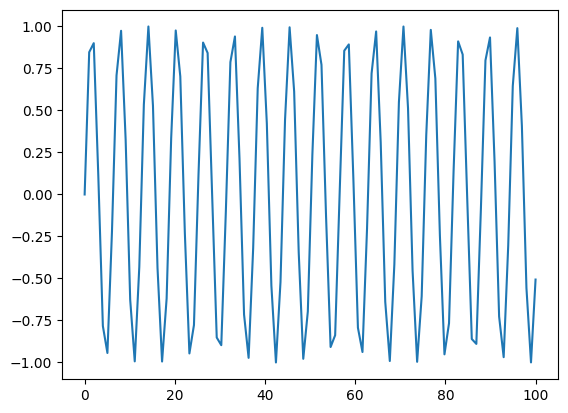

In [11]:
plt.plot(t,true_data)

In [36]:
device = torch.device('cpu')

In [37]:
data_dim = 1  # We model 1d data to easily visualize it
hidden_dim = 16

# Create a 3-layer MLP as the ODE function f(h, t)
odefunc = ODEFunc(device, data_dim, hidden_dim, time_dependent=True)

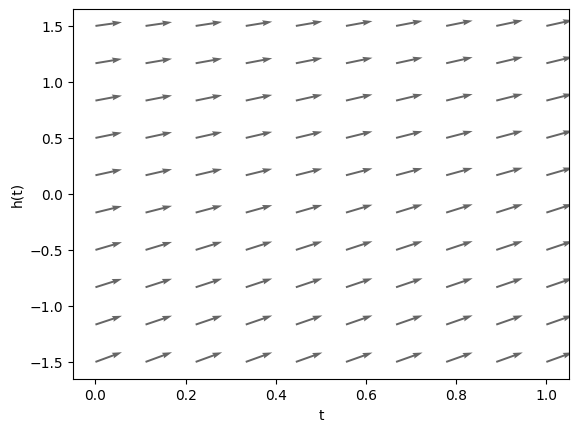

In [38]:
from viz.plots import vector_field_plt

vector_field_plt(odefunc, num_points=10, timesteps=10, 
                 h_min=-1.5, h_max=1.5)

In [62]:

from torch.utils.data import DataLoader


dataloader_easy = DataLoader(true_data, batch_size=2, shuffle=False)


In [81]:
t_vec = torch.ones(true_data.shape[0], 1).to(device) * t

In [87]:
t_vec

tensor([[  0.0000,   1.0101,   2.0202,  ...,  97.9798,  98.9899, 100.0000],
        [  0.0000,   1.0101,   2.0202,  ...,  97.9798,  98.9899, 100.0000],
        [  0.0000,   1.0101,   2.0202,  ...,  97.9798,  98.9899, 100.0000],
        ...,
        [  0.0000,   1.0101,   2.0202,  ...,  97.9798,  98.9899, 100.0000],
        [  0.0000,   1.0101,   2.0202,  ...,  97.9798,  98.9899, 100.0000],
        [  0.0000,   1.0101,   2.0202,  ...,  97.9798,  98.9899, 100.0000]])

In [56]:
from anode.models import ODEBlock
from anode.training import Trainer

data_dim = 1
hidden_dim = 16

# Create a model for the easy function
odefunc_easy = ODEFunc(device, data_dim, hidden_dim, 
                       time_dependent=True)
model_easy = ODEBlock(device, odefunc_easy)

In [57]:
optimizer_easy = torch.optim.Adam(model_easy.parameters(), lr=1e-3)

In [58]:
trainer_easy = Trainer(model_easy, optimizer_easy, device, print_freq=5)

In [93]:
def get_batch(true_y, batch_size):
    num_samples = len(true_y)
    indices = np.random.choice(np.arange(num_samples - batch_size, dtype=np.int64), size=batch_size, replace=False)
    indices.sort()
    print(indices)
    batch_y0 = true_y[indices]  # (batch_size, D)
    batch_t = t[:batch_size]  # (batch_size)
    batch_y = torch.stack([true_y[indices + i] for i in range(batch_size)], dim=0)  # (batch_size, M, D)
    return batch_y0,batch_t,batch_y

In [106]:
x,c,v = get_batch(true_data,2)

[ 1 59]


In [107]:
x

tensor([0.8469, 0.0942])

In [124]:
class DWODE(nn.Module):
    """
    neural network for learning the chaotic lorenz system
    """
    def __init__(self):
        super(DWODE, self).__init__()
        self.lin = nn.Linear(2, 64)
        self.lin2 = nn.Linear(64, 128)
        self.lin3 = nn.Linear(128,256)
        self.lin4 = nn.Linear(256,2)
        self.tanh = nn.Tanh()
        

    def forward(self, t,x):
        x = self.tanh(self.lin(x))
        x = self.tanh(self.lin2(x))
        x = self.tanh(self.lin3(x))
        x = self.lin4(x)
        return x
     

In [208]:
model = DWODE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [209]:
m = odeint(model,x,c)

In [210]:
m

tensor([[0.8469, 0.0942],
        [0.9212, 0.1304]], grad_fn=<CopySlices>)

In [203]:
l = F.mse_loss(m,v)

In [204]:
l

tensor(0.2888, grad_fn=<MseLossBackward0>)

In [207]:
l.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [206]:
optimizer.step()